<a href="https://colab.research.google.com/github/ali-unlu/bank-customer-churn-analysis/blob/main/Bank_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction 

The aim of this post is to  identify and visualize factors that contribute to customer churn.  After accomplishing this goal, then I will build three prediction models to find:

1. Classify if a customer is going to churn or not  
2. Choose a model that will attach a probability to the churn to make it easier for customer service to target to prevent churn

I found this data on Kaggle and it was realesed in 2018. More informatio about the data can be found [here.](https://www.kaggle.com/kmalit/bank-customer-churn-prediction/data) 

# Data 
- __RowNumber:__ corresponds to the record (row) number and has no effect on the output.  
- __CustomerId:__ contains random values and has no effect on customer leaving the bank.
- __Surname:__ the surname of a customer has no impact on their decision to leave the bank.
- __CreditScore:__ can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.

- __Geography:__ a customer’s location can affect their decision to leave the bank.
- __Gender:__ it’s interesting to explore whether gender plays a role in a customer leaving the bank.

- __Age:__ this is certainly relevant, since older customers are less likely to leave their bank than younger ones.

- __Tenure:__ refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.

- __Balance:__ also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.

- __NumOfProducts:__ refers to the number of products that a customer has purchased through the bank.

- __HasCrCard:__ denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.

- __IsActiveMember:__ active customers are less likely to leave the bank.

- __EstimatedSalary:__ as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.

- __Exited:__ whether or not the customer left the bank. (0=No,1=Yes)



In [1]:
from google.colab import drive
drive.mount('/content/drive')
# set the folder
import sys
sys.path.append('/content/drive/MyDrive/Python/IBM Machine Learning/Classification/Assigment')

Mounted at /content/drive


In [2]:
# required packages
import os, seaborn as sns, pandas as pd, numpy as np,  matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [36]:
# Data loading and initial checks
filepath = '/content/drive/MyDrive/Python/IBM Machine Learning/Classification/Assignment/Churn_Modelling.csv'
data = pd.read_csv(filepath, sep=',')

First I will check the dimension and types of the data

In [4]:
data.shape

(10000, 14)

In [5]:
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Data has 14 variables, three of them are objects and our target variable is __Exited__, which points out the churn status of the customer. I will also look at the first rows of the variables as well.

In [41]:
# Drop the columns as explained above
data = data.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [7]:
data.head().T

,0,1,2,3,4
CreditScore,619,608,502,699,850
Geography,France,Spain,France,France,Spain
Gender,Female,Female,Female,Female,Female
Age,42,41,42,39,43
Tenure,2,1,8,1,2
Balance,0,83807.9,159661,0,125511
NumOfProducts,1,1,3,2,1
HasCrCard,1,0,1,0,1
IsActiveMember,1,1,0,0,1
EstimatedSalary,101349,112543,113932,93826.6,79084.1


In [8]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Variable types seems to be in right format and we do not need surnames of the customers. Row ID is the index of the data and customer ID is also a unique value that identifes customers (we also do not need too). So, when we exclude target variable, we have variables that could be served as features but I will explore them in EDA section. 

__Missing values:__ It is very good that the data has no missing variable, which is very unusual in normal situation. 

# EDA 
First, we can start with the target variable and we need to check whether it is a balanced variable. Results show that it is not a balanced output, the ratio is 20% - 80%, so we can also test different methods (down and up sampling etc) to see to what extend it affects our results

In [9]:
data['Exited'].value_counts(normalize = 'True')

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In the second stage, we can check out the unique values of features, which will show us how many binary or ordinal variables we have. 

In [10]:
data_uniques = pd.DataFrame([[i, len(data[i].unique())] for i in data.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
data_uniques

,Unique Values
Variable,
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4
HasCrCard,2
IsActiveMember,2


In [11]:
binary_variables = list(data_uniques[data_uniques['Unique Values'] == 2].index) 
binary_variables


['Gender', 'HasCrCard', 'IsActiveMember', 'Exited']

Three features, 1- Gender, 2- Has a credit card, 3- is active member, are binary variables.  

In [12]:
# Categorical variables
categorical_variables = list(data_uniques[(6 >= data_uniques['Unique Values']) & (data_uniques['Unique Values'] > 2)].index)
categorical_variables

['Geography', 'NumOfProducts']

In [13]:
numeric_variables = list(set(data.columns) - set(categorical_variables) - set(binary_variables))
numeric_variables

['Age', 'Balance', 'EstimatedSalary', 'Tenure', 'CreditScore']

In [14]:
data.HasCrCard.value_counts(normalize='True')

1    0.7055
0    0.2945
Name: HasCrCard, dtype: float64

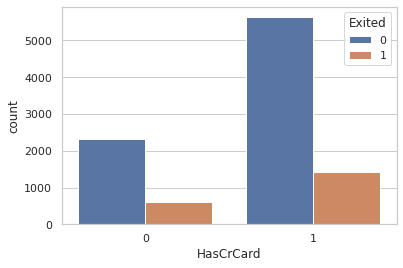

In [15]:
sns.countplot(x= 'HasCrCard', hue= 'Exited', data= data)

Around 80% of the customers have credit card and it seems that credit card owners have higher churn rate compared to who has no credit card. 

In [16]:
data.Gender.value_counts(normalize='True')

Male      0.5457
Female    0.4543
Name: Gender, dtype: float64

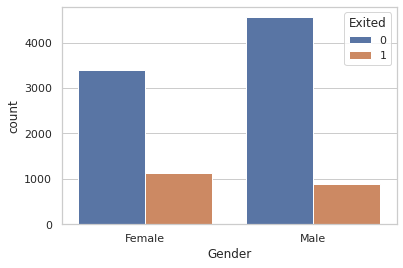

In [17]:
sns.countplot(x='Gender', hue='Exited', data= data)

In [18]:
data.IsActiveMember.value_counts(normalize='True')

1    0.5151
0    0.4849
Name: IsActiveMember, dtype: float64

The gender distribution seems to be good, and females have more churn rate compared to males. 

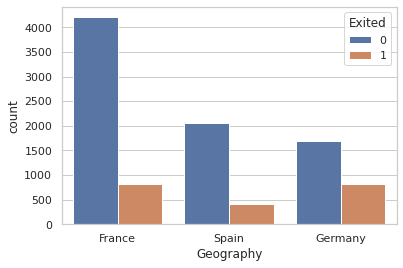

In [19]:
sns.countplot(x= 'Geography', hue='Exited', data= data)

In [20]:
data.Geography.value_counts(normalize='True')

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

Half of the customers are from France the rest is Spain and Germany with a similar ratio. On the other hand, half of the German customers seems to churn, which needs special attention. 

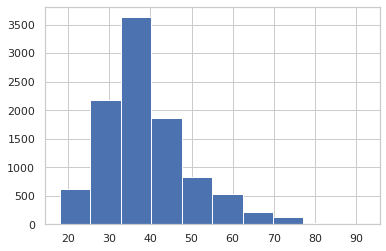

In [21]:
data.Age.hist()

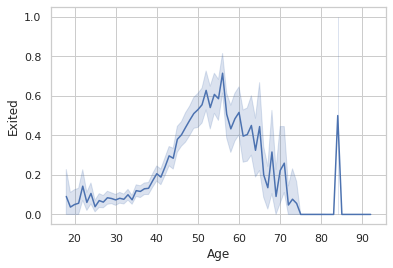

In [22]:
sns.lineplot(x='Age', y= 'Exited', data= data)

The distribution of age seems fine (still skewed but not a major issue here). On the other hand, line graph shows that customers between the age of 40 and 70 have a higher churn rate and it highest points is around at the age of 55. After the age of 80, there seems to be an outlier issue. 

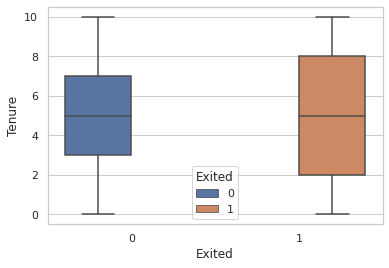

In [23]:
sns.boxplot(y= 'Tenure', x= 'Exited', hue= 'Exited', data= data)

The box plot distribution shows that bank best serve between 3-7 years tenure range. Customers in this tenure range tend to stay in bank but bank loses on the upper and lower range of tenure.  

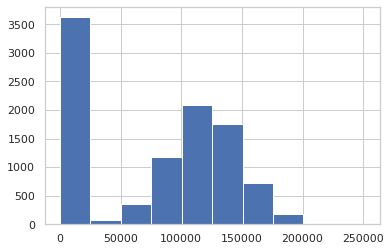

In [24]:
data.Balance.hist() # categoric

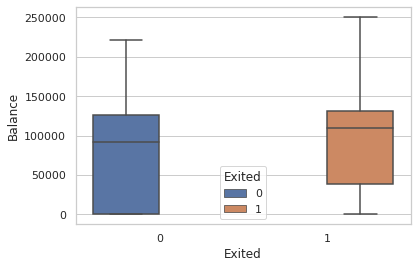

In [25]:
sns.boxplot(y="Balance", x="Exited", hue= 'Exited', data=data)


Around third of the customer have __0__ balance. On the other hand, customers who have a higher balance amount have a higher churn rate. 

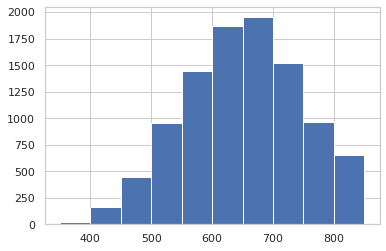

In [26]:
data.CreditScore.hist()

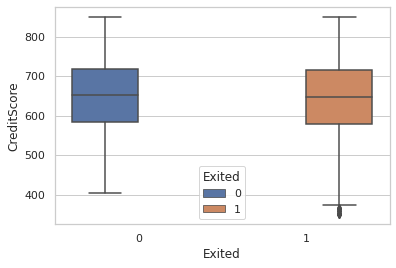

In [27]:
    sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = data)


Credit Score distribution is slightly skewed but it is still normally distributed. There is no churn difference in this category. 

In [28]:
data.NumOfProducts.value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

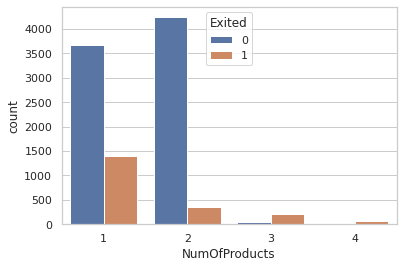

In [29]:
sns.countplot(x='NumOfProducts', hue= 'Exited', data= data)

The distribution of the customers who has more product highle skewed as expected. Although there are few customers how gets more than two products, they tend to churn on a very high ratio. 

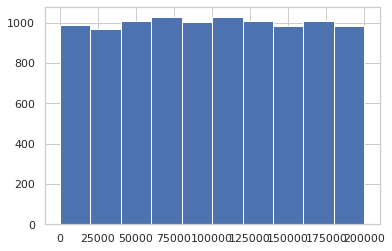

In [30]:
data.EstimatedSalary.hist()

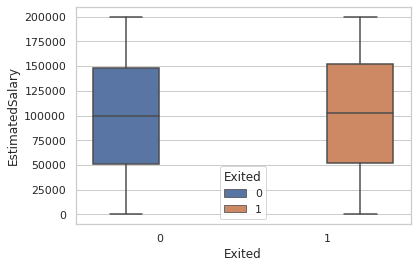

In [31]:
sns.boxplot(y='EstimatedSalary', x= 'Exited', hue= 'Exited', data= data)

There is also no difference between expected salary range in terms of their churn rate. 

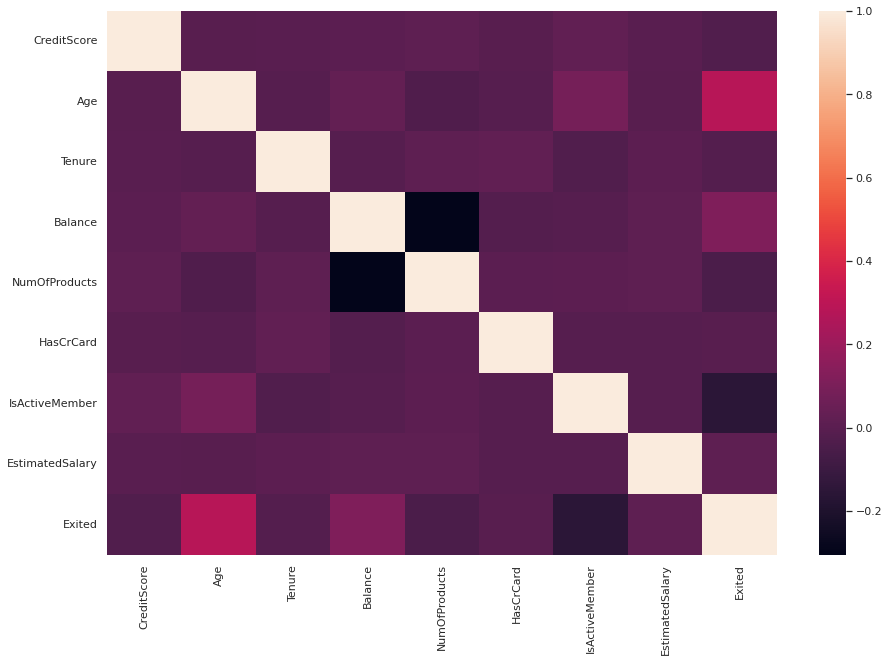

In [32]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(data.corr())

# Data Processing


In [37]:
data = pd.get_dummies(data, columns = binary_variables[0:3], drop_first=True) # kept target variable out of the dummy processing
data= pd.get_dummies(data, columns= categorical_variables)
data.head().T

,0,1,2,3,4
RowNumber,1,2,3,4,5
CustomerId,15634602,15647311,15619304,15701354,15737888
Surname,Hargrave,Hill,Onio,Boni,Mitchell
CreditScore,619,608,502,699,850
Age,42,41,42,39,43
Tenure,2,1,8,1,2
Balance,0,83807.9,159661,0,125511
EstimatedSalary,101349,112543,113932,93826.6,79084.1
Exited,1,0,1,0,0
Gender_Male,0,0,0,0,0


In [38]:
from sklearn.preprocessing import MinMaxScaler 
mm = MinMaxScaler()

In [39]:
for column in [ numeric_variables]: # binary olanlari scale etmeye gerek yok
    data[column] = mm.fit_transform(data[column])

In [42]:
round(data.describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,0.601,0.193,0.0,0.468,0.604,0.736,1.0
Age,10000.0,0.283,0.142,0.0,0.189,0.257,0.351,1.0
Tenure,10000.0,0.501,0.289,0.0,0.300,0.500,0.700,1.0
Balance,10000.0,0.305,0.249,0.0,0.000,0.387,0.509,1.0
EstimatedSalary,10000.0,0.500,0.288,0.0,0.255,0.501,0.747,1.0
Exited,10000.0,0.204,0.403,0.0,0.000,0.000,0.000,1.0
Gender_Male,10000.0,0.546,0.498,0.0,0.000,1.000,1.000,1.0
HasCrCard_1,10000.0,0.706,0.456,0.0,0.000,1.000,1.000,1.0
IsActiveMember_1,10000.0,0.515,0.500,0.0,0.000,1.000,1.000,1.0
Geography_France,10000.0,0.501,0.500,0.0,0.000,1.000,1.000,1.0


In [43]:
from sklearn.model_selection import StratifiedShuffleSplit

target = 'Exited'

feature_cols = [x for x in data.columns if x != target]


# Split the data into two parts with 1500 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data[target]))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, target]

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, target]

In [44]:
y_train.value_counts(normalize=True)

0    0.796286
1    0.203714
Name: Exited, dtype: float64

In [45]:
y_test.value_counts(normalize=True)


0    0.796333
1    0.203667
Name: Exited, dtype: float64

# Model 1: Logistic regression

In [46]:
from sklearn.linear_model import LogisticRegression


# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [138]:
print("Test accurarcy {}".format(lr.score(X_test,y_test)))


Test accurarcy 0.844


### GridSearch 

In [56]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression - Lasso model 
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)



In [57]:
print("Test accurarcy {}".format(lr_l1.score(X_test,y_test)))


Test accurarcy 0.8466666666666667


In [58]:
# L2 regularized logistic regression- Ridge regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)


In [59]:
print("Test accurarcy {}".format(lr_l2.score(X_test,y_test)))


Test accurarcy 0.844


In [63]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score


In [71]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

y_pred = lr_l1.predict(X_test) # we use the lasso model 

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2389
           1       0.74      0.38      0.50       611

    accuracy                           0.85      3000
   macro avg       0.80      0.67      0.70      3000
weighted avg       0.84      0.85      0.83      3000

   accuracy  precision    recall   f1       auc
0  0.846667   0.744337  0.376432  0.5  0.671682


Text(0.5, 73.5, 'Ground Truth')

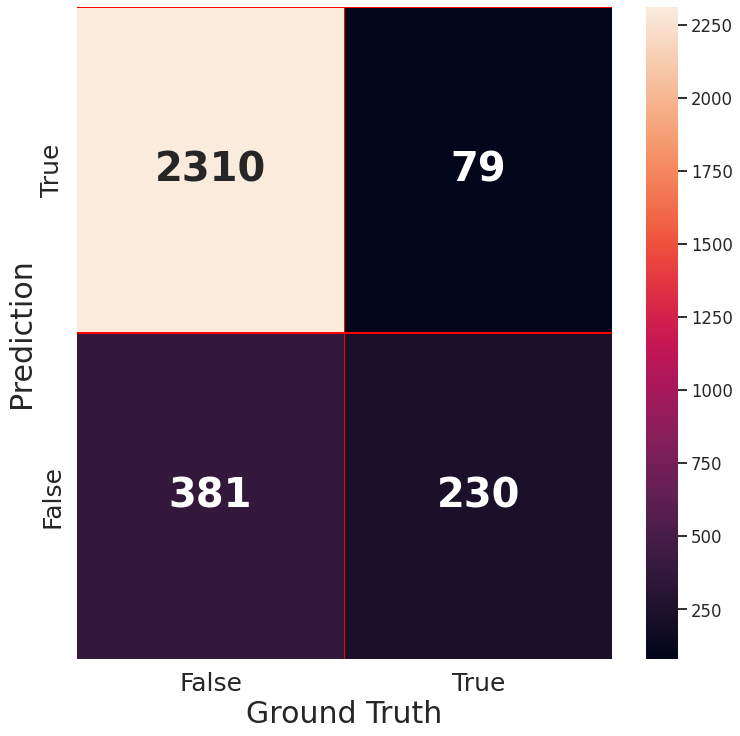

In [72]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cm, annot=True, fmt='d', linewidths=0.5, linecolor='red', annot_kws={"size": 40, "weight": "bold"})

labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

# Model 2: KNN 

In [81]:
from sklearn.neighbors import KNeighborsClassifier


In [82]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2389
           1       0.56      0.43      0.48       611

    accuracy                           0.82      3000
   macro avg       0.71      0.67      0.69      3000
weighted avg       0.80      0.82      0.81      3000

Accuracy score:  0.82
F1 Score:  0.48


Text(0.5, 73.5, 'Ground Truth')

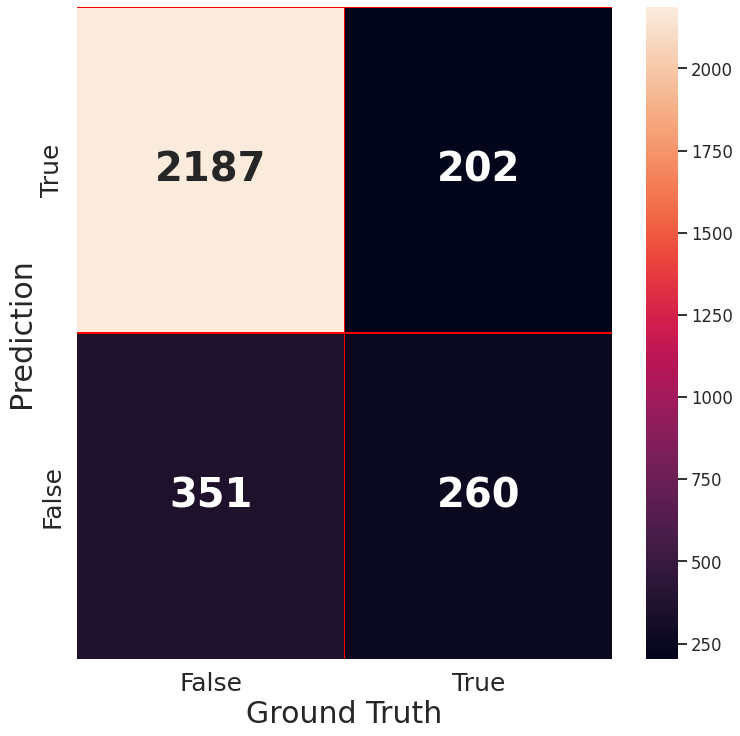

In [83]:
# Plot confusion matrix
#sns.set_palette(sns.color_palette(colors))
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', linewidths=0.5, linecolor='red', annot_kws={"size": 40, "weight": "bold"})  
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

We can also calculate the optimum k number and re-run the analysis 

In [84]:
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1800x1200 with 0 Axes>

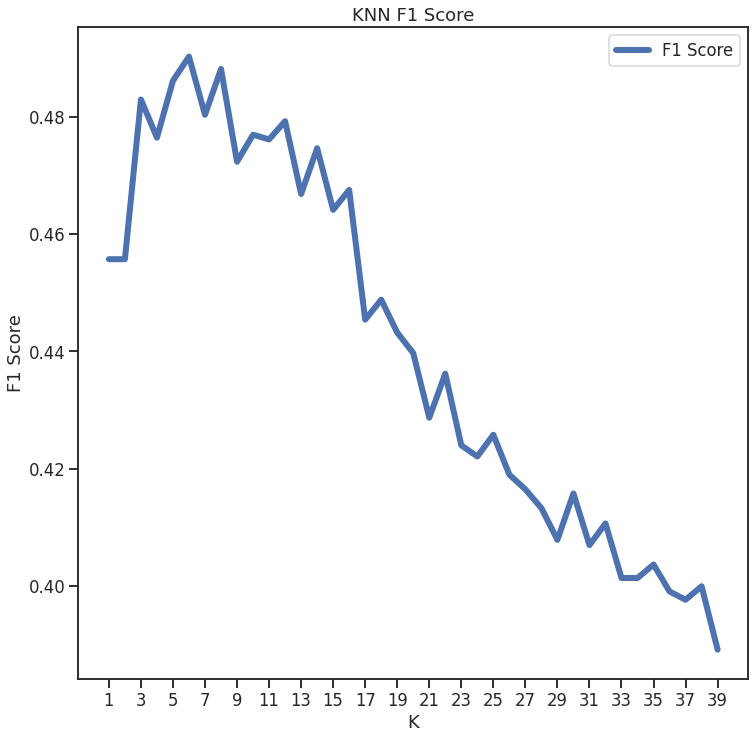

In [85]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot( figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

<Figure size 1800x1200 with 0 Axes>

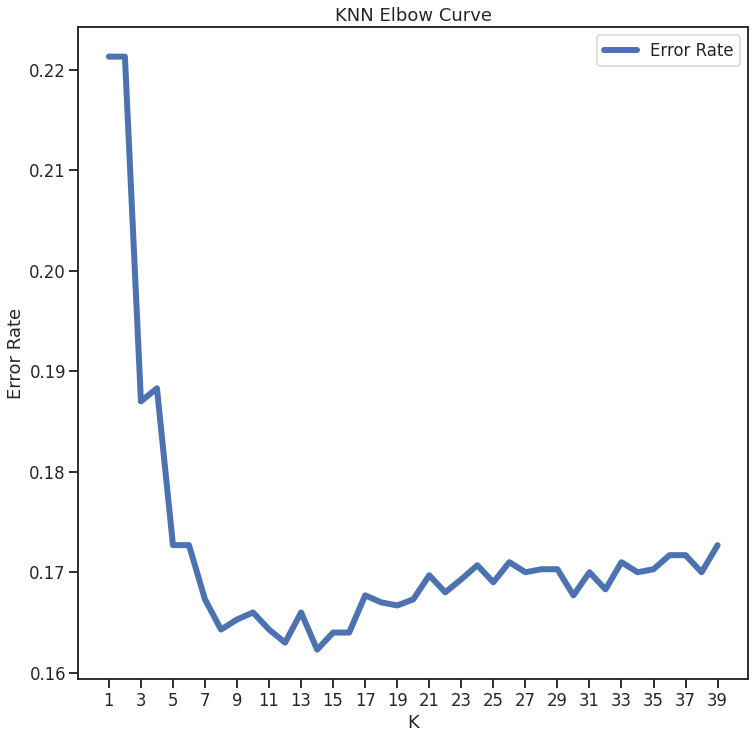

In [86]:
# Plot Accuracy (Error Rate) results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot( figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')

It seems that k=8 or k=9 is the optimum value and I will use 9 for the rest of the analysis.  

In [90]:
knn = KNeighborsClassifier(n_neighbors=9)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      2389
           1       0.67      0.36      0.46       611

    accuracy                           0.83      3000
   macro avg       0.76      0.66      0.68      3000
weighted avg       0.82      0.83      0.81      3000

Accuracy score:  0.83
F1 Score:  0.46


Text(0.5, 73.5, 'Ground Truth')

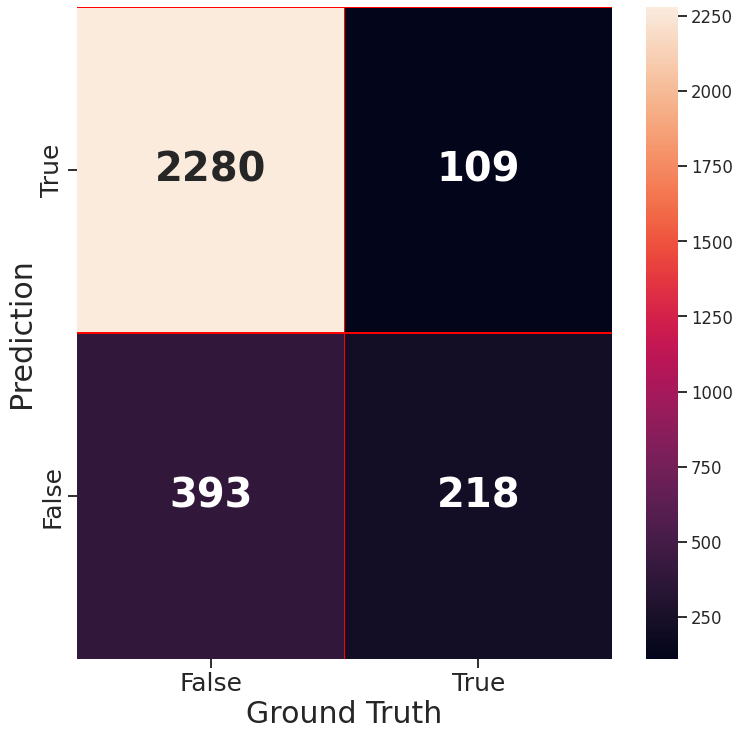

In [91]:
# Plot confusion matrix
#sns.set_palette(sns.color_palette(colors))
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', linewidths=0.5, linecolor='red', annot_kws={"size": 40, "weight": "bold"})  
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

The model improved when we set k to 7 but it is still beyond the expected level 

# Model 3: Random Forest


In [92]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [94]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
RF = RandomForestClassifier(oob_score=True, # out of bag score
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

,oob
n_trees,
15.0,0.159000
20.0,0.158429
30.0,0.151571
40.0,0.147857
50.0,0.148714
100.0,0.141429
150.0,0.142429
200.0,0.141571
300.0,0.140143


In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

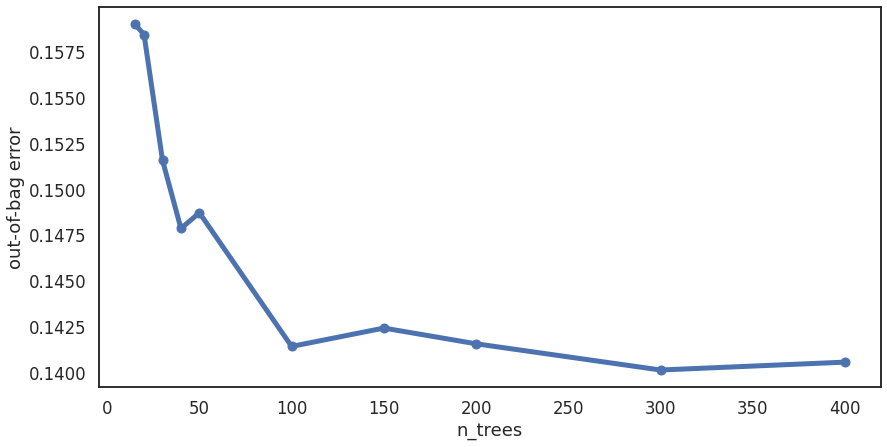

In [96]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [97]:
# Random forest with 100 estimators
rf_final_model = RF.set_params(n_estimators=100)

y_pred = rf_final_model.predict(X_test)

In [187]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.76      0.48      0.58       611

    accuracy                           0.86      3000
   macro avg       0.82      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000

   accuracy  precision    recall        f1      auc
0  0.862333   0.757812  0.476268  0.584925  0.71867


Text(0.5, 73.5, 'Ground Truth')

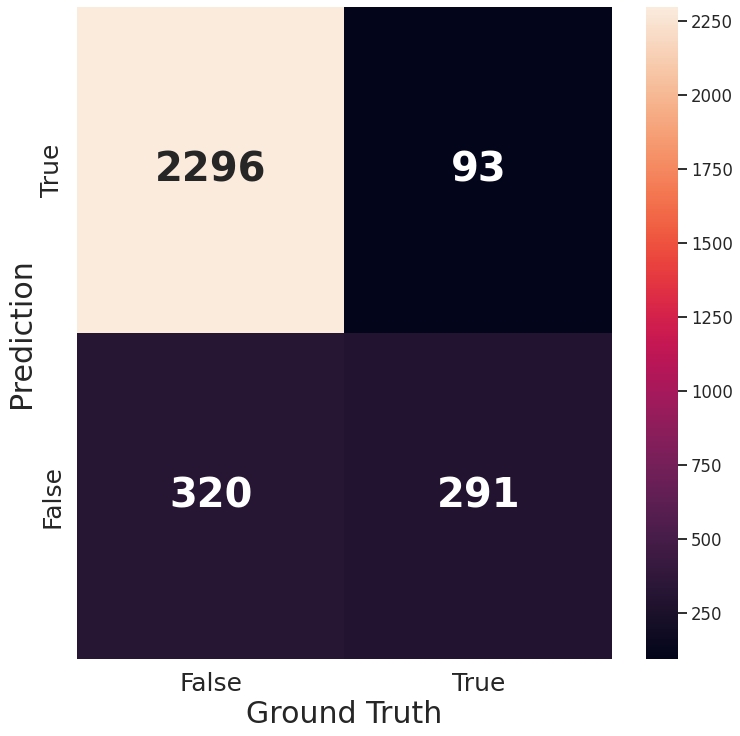

In [98]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cm, annot=True, fmt='d',  annot_kws={"size": 40, "weight": "bold"})

labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

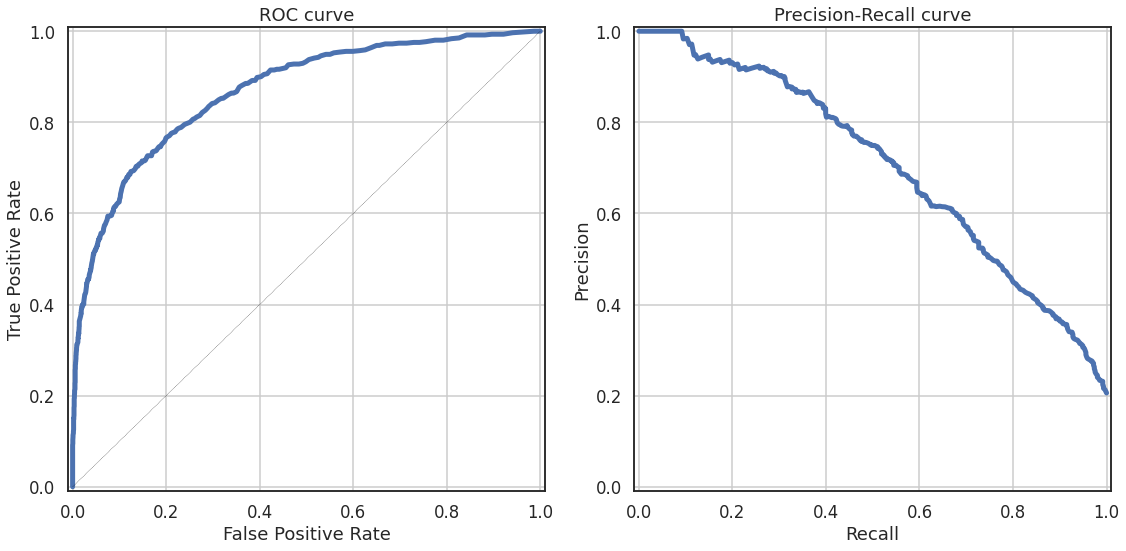

In [99]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2) # iki tane plot olacak
fig.set_size_inches(16, 8)

# Get the probabilities for each of the two categories
y_prob = rf_final_model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

# fpr = false positive rate
# tpr = true positive rate
# threshold = neresi treshold

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, linewidth=5)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3) # scale 0 ile 1 arasinda olacak
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision,  linewidth=5)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

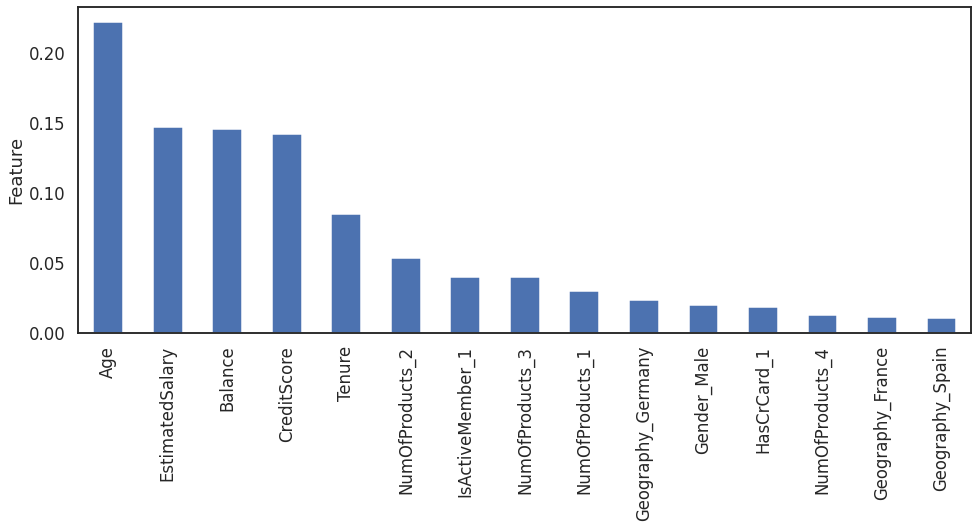

In [100]:
feature_imp = pd.Series(rf_final_model.feature_importances_, index=feature_cols).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar', figsize=(16, 6))
ax.set(ylabel='Relative Importance');
ax.set(ylabel='Feature');

# Compare the Models

I illustrate three models here with basic tuning options. Among these models, Random Forest performed better and it is followed by Logistic regression and KNN. 

In [101]:
models = [
    lr,
    knn,
    rf_final_model,
     
        ]


for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("-"*28)
    print(names + ":" )
    print("Accuracy: {:.4%}".format(accuracy))


----------------------------
LogisticRegression:
Accuracy: 84.4000%
----------------------------
KNeighborsClassifier:
Accuracy: 83.2667%
----------------------------
RandomForestClassifier:
Accuracy: 86.2333%


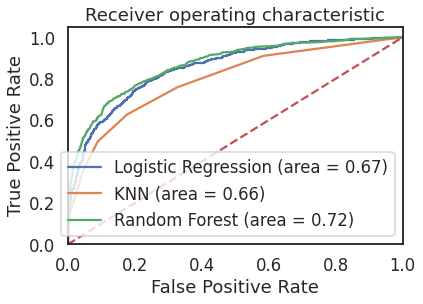

In [102]:
logistic_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])

rf_roc_auc = roc_auc_score(y_test, rf_final_model.predict(X_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_final_model.predict_proba(X_test)[:,1])

fig.set_size_inches(20, 10)
plt.figure()

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logistic_roc_auc)
plt.plot(knn_fpr, knn_tpr, label='KNN (area = %0.2f)' % knn_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Conclusion
- The model need improvement to fulfil the business expectations but the current level analysis indicates that bank needs to improve its services targetting age, salary and credit score indicators. It seems that bank loses most valuable customers who have assets and good credit score. 
- New features could be created based on current features such as manipulating tenure leves with age or digging location based indicators with other features. But keep in mind that, the more feature, the more complex model, which leads overfiting problem. 
- In this illustration, I refrain from using gridsearchCV technique, it will speed up the coding and analysis process. Instead, this shows what rests behind the gridsearch process because we analyzed the data step by step. 
- As mentioned above, the best model for this data is random forest among tested models. With the grid search, more models can be tested and compared the results. 